# CUSUM Filter
Cumulative sum https://en.wikipedia.org/wiki/CUSUM

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
df = pd.read_csv("../data/testing.csv")
df["time"] = list(map(lambda x: datetime.datetime.fromtimestamp(x/1000), df.time))
df = df.set_index(["time"], drop=True)
df = df[~df.index.duplicated(keep='first')]
len(df)

79373

In [3]:
def get_daily_vol(close, span0=100):
    """
    daily vol, reindexed to close
    
    Arguments:
    close -- daily close (probably Pandas series)
    span0 -- span lol (probably int)
    Purpose:
    use the output of this function to set default profit taking and stop-loss limit
    """
    df0 = close.index.searchsorted(close.index-pd.Timedelta(days=1))
    df0=df0[df0>0]
    df0=pd.Series(close.index[df0-1], index=close.index[close.shape[0]-df0.shape[0]:])
    df0=close.loc[df0.index]/close.loc[df0.values].values-1 # daily returns
    df0=df0.ewm(span=span0).std()
    return df0

In [4]:
vol = get_daily_vol(df.close)

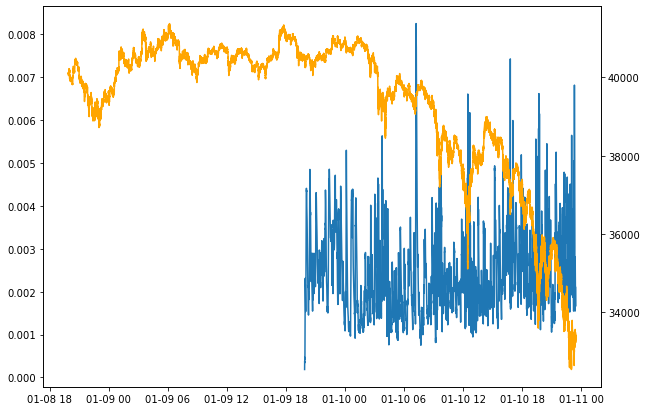

In [5]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(vol)

ax1 = ax.twinx()
ax1.plot(df.close, color='orange')

In [6]:
def get_t_events(gRaw, h):
    tEvents, sPos, sNeg = [], 0, 0
    diff = np.log(gRaw).diff().dropna()
    for i in diff.index[1:]:
        try:
            pos, neg = float(sPos+diff.loc[i]), float(sNeg+diff.loc[i])
        except Exception as e:
            print(e)
            print(sPos+diff.loc[i], type(sPos+diff.loc[i]))
            print(sNeg+diff.loc[i], type(sNeg+diff.loc[i]))
            break
        sPos, sNeg=max(0., pos), min(0., neg)
        if sNeg<-h:
            sNeg=0;tEvents.append(i)
        elif sPos>h:
            sPos=0;tEvents.append(i)
    return pd.DatetimeIndex(tEvents)

In [7]:
t_events = get_t_events(df.close,h=vol.mean())
t_events

DatetimeIndex(['2021-01-08 19:57:56.847000', '2021-01-08 20:01:42.971000',
               '2021-01-08 20:02:14.242000', '2021-01-08 20:02:40.178000',
               '2021-01-08 20:04:59.035000', '2021-01-08 20:13:07.605000',
               '2021-01-08 20:18:48.288000', '2021-01-08 20:21:14.739000',
               '2021-01-08 20:22:50.773000', '2021-01-08 20:23:21.807000',
               ...
               '2021-01-10 23:23:15.016000', '2021-01-10 23:23:42.399000',
               '2021-01-10 23:23:55.817000', '2021-01-10 23:24:03.733000',
               '2021-01-10 23:24:24.929000', '2021-01-10 23:24:28.092000',
               '2021-01-10 23:25:02.191000', '2021-01-10 23:25:37.310000',
               '2021-01-10 23:25:54.102000', '2021-01-10 23:26:00.159000'],
              dtype='datetime64[ns]', length=3528, freq=None)

In [8]:
d = {"time":t_events, "event":np.ones(3528)}

In [9]:
d = pd.DataFrame(d)

In [10]:
test = []
for row in range(len(d)):
    test.append(df.loc[d.iloc[row].time].close)

In [11]:
df.loc[d.iloc[1].time].close

40120.0

In [12]:
d["event"] = test

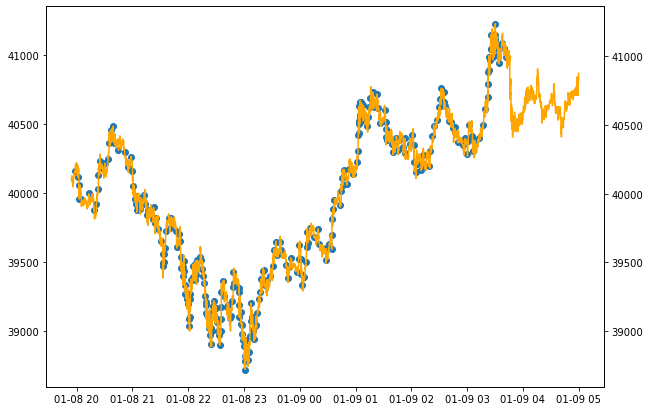

In [13]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(d.time[:300], d.event[:300])

ax1 = ax.twinx()
ax1.plot(df.close[:10000], color='orange')

## Add vertical barriers

In [14]:
def addVerticalBarrier(tEvents, close, numDays=1):
    t1=close.index.searchsorted(tEvents+pd.Timedelta(days=numDays))
    t1=t1[t1<close.shape[0]]
    t1=(pd.Series(close.index[t1],index=tEvents[:t1.shape[0]]))
    return t1

In [15]:
t1 = addVerticalBarrier(t_events, df.close, numDays=1)
t1

2021-01-08 19:57:56.847   2021-01-09 19:58:02.136
2021-01-08 20:01:42.971   2021-01-09 20:01:46.999
2021-01-08 20:02:14.242   2021-01-09 20:02:18.078
2021-01-08 20:02:40.178   2021-01-09 20:02:50.652
2021-01-08 20:04:59.035   2021-01-09 20:05:07.081
                                    ...          
2021-01-09 23:00:05.626   2021-01-10 23:00:06.758
2021-01-09 23:13:07.833   2021-01-10 23:13:08.116
2021-01-09 23:14:01.039   2021-01-10 23:14:02.174
2021-01-09 23:14:13.910   2021-01-10 23:14:15.963
2021-01-09 23:17:58.636   2021-01-10 23:17:58.851
Name: time, Length: 739, dtype: datetime64[ns]

## Apply triple barrier

In [66]:
def mpPandasObj(func,pdObj,numThreads=24,mpBatches=1,linMols=True,**kargs):
    '''
    Parallelize jobs, return a dataframe or series
    + func: function to be parallelized. Returns a DataFrame
    + pdObj[0]: Name of argument used to pass the molecule
    + pdObj[1]: List of atoms that will be grouped into molecules
    + kwds: any other argument needed by func
    
    Example: df1=mpPandasObj(func,('molecule',df0.index),24,**kwds)
    '''
    import pandas as pd
    #if linMols:parts=linParts(len(argList[1]),numThreads*mpBatches)
    #else:parts=nestedParts(len(argList[1]),numThreads*mpBatches)
    if linMols:parts=linParts(len(pdObj[1]),numThreads*mpBatches)
    else:parts=nestedParts(len(pdObj[1]),numThreads*mpBatches)
    
    jobs=[]
    for i in range(1,len(parts)):
        job={pdObj[0]:pdObj[1][parts[i-1]:parts[i]],'func':func}
        job.update(kargs)
        jobs.append(job)
    if numThreads==1:out=processJobs_(jobs)
    else: out=processJobs(jobs,numThreads=numThreads)
    if isinstance(out[0],pd.DataFrame):df0=pd.DataFrame()
    elif isinstance(out[0],pd.Series):df0=pd.Series()
    else:return out
    for i in out:df0=df0.append(i)
    df0=df0.sort_index()
    return df0

def apply_triple_barrier(close, events, pt_sl, molecule):
    """
    apply stop loss /profit taking, if it takes place between t1 (end of event)
    
    Arguments:
    close -- pandas series of prices
    events -- pandas dataframe with columns:
        t1: The timestamp of vertical barrier. When the value is np.nan, there will not be a vertical barrier
        trgt: The unit width of the horizontal barriers
    pt_sl -- a list of two non-negative float values:
        pt_sl[0] -- the factor that multiplies trgt to set the width of the upper barrier. If 0, there will not be an upper barrier
        pt_sl[1] -- the factor that multiples trgt to set the width of the lower barrier. If 0, there will not be a lower barrier
    molecule -- A list with the subset of event indices that will be processed by a single thread
    
    Output:
    The output from this function is a pandas dataframe containing the timestamps (if any) at which each barrier was touched.
    """
    events0 = events.loc[molecule]
    out = events0[['t1']].copy(deep=True)
    if pt_sl[0]>0:
        pt=pt_sl[0]*events0['trgt']
    else:
        pt=pd.Series(index=events.index) #NaNs
    if pt_sl[1]>0:
        sl=-pt_sl[1]*events0['trgt']
    else:
        sl=pd.Series(index=events.index) #NaNs
    for loc, t1 in events0['t1'].fillna(close.index[-1]).iteritems():
        df0=close[loc:t1] #path prices
        df0=(df0/close[loc]-1)*events0.at[loc, 'side'] #path returns
        out.loc[loc, 'sl']=df0[df0<sl[loc]].index.min() #earliest stop loss
        out.loc[loc, 'pt']=df0[df0>pt[loc]].index.min() #earliest profit taking
    return out

In [70]:
def get_events(close, t_events, pt_sl, trgt, min_ret, num_threads, t1=False):
    """
    finds the time of the first barrier touch
    
    Arguments:
    close -- a pandas series of prices
    t_events -- the pandas timeindex containing the timestamps that will seed every triple barrier. These are the timestamps discussed in section 2.5
    pt_sl -- a non-negative float that sets the width of the two barriers. A 0 value means that the respective horizontal barrier (profit taking and/or stop loss) will be disabled
    t1 -- a pandas series with the timestamps of the vertical barriers. We pass a False when we watn to disable vertical barriers
    trgt -- a pandas series of targets, expressed in terms of absolute returns
    min_ret -- the minimum target return required for running a triple barrier search
    num_threads -- the number of threads concurrently used by the function
    
    Output:
    pandas dataframe with columns
    t1 -- the timestamp at which the first barrier is touched
    trgt -- the target that was used to generate the horizontal barriers
    """
    #Get target
#     trgt = trgt.loc[t_events]
    trgt = trgt.reindex(t_events)

    trgt = trgt[trgt>min_ret] #min_ret
    
    #Get t1 (max holding period)
    if t1 is False:
        t1=pd.Series(pd.NaT, index=t_events)
    # form events object, apply stop loss on t1
    side0 = pd.Series(1., index=trgt.index)
    print(side0)
    events=pd.concat({'t1':t1, 'trgt':trgt, 'side':side0},
                    axis=1).dropna(subset=['trgt'])
#     df0=mpPandasObj(func=apply_triple_barrier, pdObj=('molecule', events.index),
#                    numThreads=num_threads, close=close, events=events, ptSL=[pt_sl, pt_sl])
    df0 = apply_triple_barrier(close, events, pt_sl, events.index)
    events['t1']=df0.dropna(how='all').min(axis=1) #pd.min ignores nan
    events=events.drop('side', axis=1)
    return events

In [62]:
trgt = target.reindex(t_events)

In [63]:
trgt

2021-01-08 19:57:56.847         NaN
2021-01-08 20:01:42.971         NaN
2021-01-08 20:02:14.242         NaN
2021-01-08 20:02:40.178         NaN
2021-01-08 20:04:59.035         NaN
                             ...   
2021-01-10 23:24:28.092    0.002268
2021-01-10 23:25:02.191    0.002139
2021-01-10 23:25:37.310    0.001870
2021-01-10 23:25:54.102    0.001681
2021-01-10 23:26:00.159    0.001909
Name: close, Length: 3528, dtype: float64

In [60]:
t_events[3000]

Timestamp('2021-01-10 21:45:03.271000')

In [61]:
target[t_events[3000]]

0.001837861917544121

In [41]:
trgt

2021-01-08 19:57:56.847   NaN
2021-01-08 20:01:42.971   NaN
2021-01-08 20:02:14.242   NaN
2021-01-08 20:02:40.178   NaN
2021-01-08 20:04:59.035   NaN
                           ..
2021-01-10 23:24:28.092   NaN
2021-01-10 23:25:02.191   NaN
2021-01-10 23:25:37.310   NaN
2021-01-10 23:25:54.102   NaN
2021-01-10 23:26:00.159   NaN
Name: close, Length: 3528, dtype: float64

In [71]:
# create target series
ptsl = [1,1]
target=vol
# select minRet
minRet = 0.0001

# Run in single-threaded mode on Windows
    
events = get_events(df.close,t_events,ptsl,target,minRet,1,t1=t1)


2021-01-09 19:56:34.575    1.0
2021-01-09 19:58:15.444    1.0
2021-01-09 19:58:30.182    1.0
2021-01-09 20:01:02.852    1.0
2021-01-09 20:03:06.049    1.0
                          ... 
2021-01-10 23:24:28.092    1.0
2021-01-10 23:25:02.191    1.0
2021-01-10 23:25:37.310    1.0
2021-01-10 23:25:54.102    1.0
2021-01-10 23:26:00.159    1.0
Length: 2849, dtype: float64


In [72]:
events

,t1,trgt
2021-01-09 19:56:34.575,2021-01-09 19:56:57.036,0.000510
2021-01-09 19:58:15.444,2021-01-09 19:58:30.182,0.001966
2021-01-09 19:58:30.182,2021-01-09 20:00:25.179,0.002218
2021-01-09 20:01:02.852,2021-01-09 20:02:02.665,0.001612
2021-01-09 20:03:06.049,2021-01-09 20:14:42.323,0.002897
...,...,...
2021-01-10 23:24:28.092,2021-01-10 23:25:02.191,0.002268
2021-01-10 23:25:02.191,2021-01-10 23:25:52.641,0.002139
2021-01-10 23:25:37.310,2021-01-10 23:25:54.247,0.001870
2021-01-10 23:25:54.102,2021-01-10 23:25:55.044,0.001681


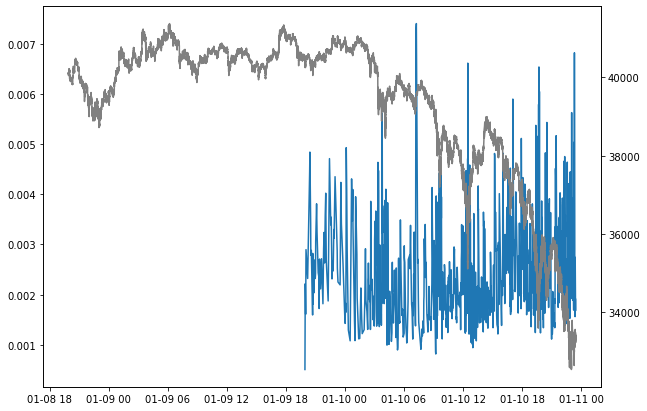

In [76]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(events.index, events.trgt)

ax1 = ax.twinx()
ax1.plot(df.close, color="gray")

## Apply getBins to generate the labels.

In [77]:
def get_bins(events, close):
    """
    Output:
    dataframe with columns:
    ret -- the return realized at the time of the first touched barrier
    bin -- the label, {-1, 0, 1}, as a function of the sign of the outcome. The funciton can be easily adjusted to label as 0 those events when the vertical barrier was touched first"""
    # prices aligned with events
    events0 = events.dropna(subset=['t1'])
    px=events0.index.union(events0['t1'].values).drop_duplicates()
    px=close.reindex(px, method='bfill')
    # Create out object
    out=pd.DataFrame(index=events0.index)
    out['ret']=px.loc[events0['t1'].values].values/px.loc[events0.index]-1
    out['bin']=np.sign(out['ret'])
    return out

In [79]:
labels = get_bins(events, df.close)
labels

,ret,bin
2021-01-09 19:56:34.575,-0.000682,-1.0
2021-01-09 19:58:15.444,0.002166,1.0
2021-01-09 19:58:30.182,-0.002492,-1.0
2021-01-09 20:01:02.852,0.001797,1.0
2021-01-09 20:03:06.049,0.003038,1.0
...,...,...
2021-01-10 23:24:24.929,-0.003388,-1.0
2021-01-10 23:24:28.092,0.002720,1.0
2021-01-10 23:25:02.191,-0.002214,-1.0
2021-01-10 23:25:37.310,-0.003005,-1.0


## Miscellaneous

In [117]:
def get_t_events(g_raw, h):
    """
    Implementation of the symmetric CUSUM filter seen in chapter 2.5.2
    
    Arguments:
    g_raw -- the raw time series to filter (possibly pandas series)
    h -- threshold (possibly float or int)
    
    Purpose:
    The CUSUM filter is a quality-control method, designed to detect a shift in the mean value of a measured quantity away from a target value. 
    """
    t_events, s_pos, s_neg = [], 0, 0
    diff = g_raw.diff()
    for i in diff.index[1:]:
        s_pos, s_neg = max(0, s_pos+diff.loc[i]), min(0, s_neg+diff.loc[i])
        if s_neg<-h[i]:
            s_neg = 0
            t_events.append(i)
        elif s_pos>h[i]:
            s_pos = 0
            t_events.append(i)
        else:
            t_events.append(None)
    return t_events

In [126]:
a = get_t_events(df.close, 500)
a = [None] + a

In [127]:
b = list(map(lambda x, c: c if x != None else None, a, df.close))

In [128]:
len(a)

79373

In [129]:
len(df.close)

79373

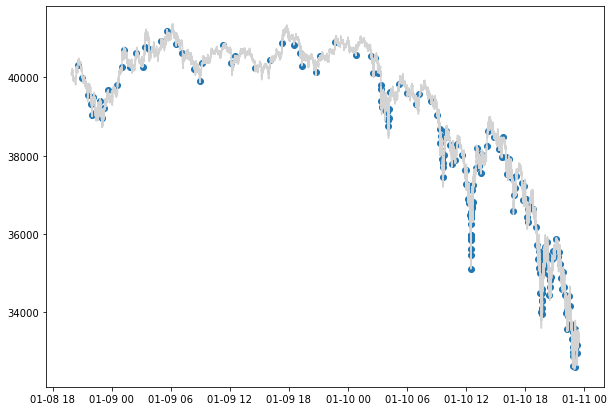

In [130]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(df.close.index, b)

ax.plot(df.close, color="lightgrey")
